# =====================================================
# TASK 2: DEEP LEARNING FOR IMAGE CLASSIFICATION
# Dataset: Microsoft Cats vs Dogs (Kaggle)
# Framework: TensorFlow (Keras)
# =====================================================


In [111]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.2


In [112]:
DATA_DIR = "PetImages"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32


In [113]:
image_paths = []
labels = []

for label, class_name in enumerate(["Cat", "Dog"]):
    class_dir = os.path.join(DATA_DIR, class_name)
    for file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, file))
        labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total images:", len(image_paths))


Total images: 25002


In [114]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Training images:", len(train_paths))
print("Validation images:", len(val_paths))


Training images: 20001
Validation images: 5001


In [115]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


In [116]:
def build_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Ignore corrupted images WITHOUT breaking labels
    ds = ds.apply(tf.data.experimental.ignore_errors())

    if training:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


In [117]:
train_ds = build_dataset(train_paths, train_labels, training=True)
val_ds   = build_dataset(val_paths, val_labels, training=False)

steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE


In [118]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [119]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/5
  1/625 ━━━━━━━━━━━━━━━━━━━━ 6:10 594ms/step - accuracy: 0.5625 - loss: 0.6903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


122/625 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.5068 - loss: 0.7434

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


219/625 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.5122 - loss: 0.7246

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


235/625 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.5134 - loss: 0.7227

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


284/625 ━━━━━━━━━━━━━━━━━━━━ 30s 88ms/step - accuracy: 0.5180 - loss: 0.7174

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


337/625 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.5238 - loss: 0.7123

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


357/625 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.5261 - loss: 0.7105

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/625 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.5403 - loss: 0.7000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


547/625 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5465 - loss: 0.6955

576/625 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5494 - loss: 0.6935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5540 - loss: 0.6902

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.6124 - loss: 0.6478 - val_accuracy: 0.6991 - val_loss: 0.5733
Epoch 2/5
122/625 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.7046 - loss: 0.5752

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


219/625 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7098 - loss: 0.5669

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


235/625 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.7105 - loss: 0.5656

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


284/625 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step - accuracy: 0.7128 - loss: 0.5619

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


337/625 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7145 - loss: 0.5589

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


357/625 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.7153 - loss: 0.5577

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/625 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.7209 - loss: 0.5493

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


547/625 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7232 - loss: 0.5457

576/625 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.7242 - loss: 0.5442

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7259 - loss: 0.5416

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.7468 - loss: 0.5093 - val_accuracy: 0.7865 - val_loss: 0.4603
Epoch 3/5
122/625 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accuracy: 0.7937 - loss: 0.4511

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


219/625 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.7967 - loss: 0.4431

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


235/625 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.7971 - loss: 0.4421

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


284/625 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - accuracy: 0.7978 - loss: 0.4396

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


337/625 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7984 - loss: 0.4378

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


357/625 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.7985 - loss: 0.4372

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/625 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.8001 - loss: 0.4337

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


547/625 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8007 - loss: 0.4321

576/625 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.8009 - loss: 0.4315

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8013 - loss: 0.4304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.8064 - loss: 0.4177 - val_accuracy: 0.8039 - val_loss: 0.4315
Epoch 4/5
122/625 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.8335 - loss: 0.3816

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


219/625 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.8331 - loss: 0.3769

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


235/625 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.8333 - loss: 0.3762

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


283/625 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.8337 - loss: 0.3745

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


336/625 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.8340 - loss: 0.3731

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


356/625 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.8341 - loss: 0.3725

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/625 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.8348 - loss: 0.3695

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


546/625 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8350 - loss: 0.3685

576/625 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8351 - loss: 0.3681

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8354 - loss: 0.3673

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 113ms/step - accuracy: 0.8399 - loss: 0.3558 - val_accuracy: 0.8357 - val_loss: 0.3792
Epoch 5/5
122/625 ━━━━━━━━━━━━━━━━━━━━ 54s 108ms/step - accuracy: 0.8610 - loss: 0.3178

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


219/625 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.8649 - loss: 0.3106

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


234/625 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.8654 - loss: 0.3098

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


283/625 ━━━━━━━━━━━━━━━━━━━━ 37s 110ms/step - accuracy: 0.8666 - loss: 0.3080

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


336/625 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.8677 - loss: 0.3063

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


356/625 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.8680 - loss: 0.3057

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/625 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8695 - loss: 0.3024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


546/625 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8700 - loss: 0.3012

575/625 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8702 - loss: 0.3007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8706 - loss: 0.2997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 119ms/step - accuracy: 0.8765 - loss: 0.2861 - val_accuracy: 0.8077 - val_loss: 0.4700


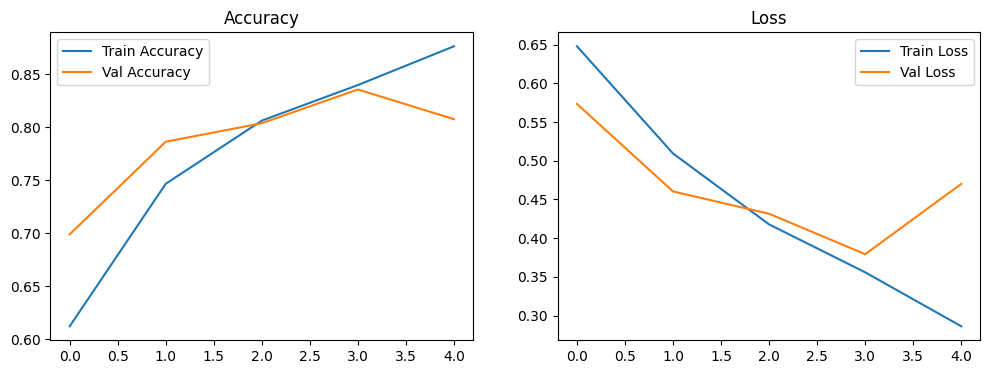

In [121]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()
